This notebook shows how to analyse several mass photometry measurements to quantify 
the equilibrium dissociation constant

The notebook is based on the following publication:

Fineberg, A., Surrey, T., & Kukura, P. (2020). Quantifying the monomer–dimer equilibrium of tubulin with mass photometry. Journal of molecular biology, 432(23), 6168-6172.

First we simulate the measurements and then we fit them.

In [1]:
from scripts import create_notebook_6_files, display_figure_static
create_notebook_6_files(
    Kdim=8.35e-9,
    monomer_mass=80,
    concentrations_nM=[1,2,4,8,16,32,64]) 
# This function creates the necessary files for the notebook
# It simulates mass photometry data for different total monomer concentrations
# The Kd value is set to 8.35 nM

# The simulated concentrations include a random error of 3% to simulate experimental conditions


Generated file: test_files/masses_monomer_1nM.csv
Generated file: test_files/masses_monomer_2nM.csv
Generated file: test_files/masses_monomer_4nM.csv
Generated file: test_files/masses_monomer_8nM.csv
Generated file: test_files/masses_monomer_16nM.csv
Generated file: test_files/masses_monomer_32nM.csv
Generated file: test_files/masses_monomer_64nM.csv


In [2]:
import os
import glob
import numpy as np
from pyphotomol import (
    MPAnalyzer,
    plot_histogram,
    plot_histograms_and_fits,
    LayoutConfig,
    LegendConfig
)

mp = MPAnalyzer()

# Get all monomer files with concentrations in filename, sorted by concentration
files = sorted(glob.glob("test_files/masses_monomer_*nM.csv"), 
                      key=lambda x: float(x.split('_')[-1].replace('nM.csv', '')))

# Extract the total monomer concentration from each filename
concentrations = [float(f.split('_')[-1].replace('nM.csv', '')) for f in files]
# Convert to string and include 'nM' suffix
concentration_strings = [f"{c} nM" for c in concentrations]

mp.import_files(files,names=concentration_strings)

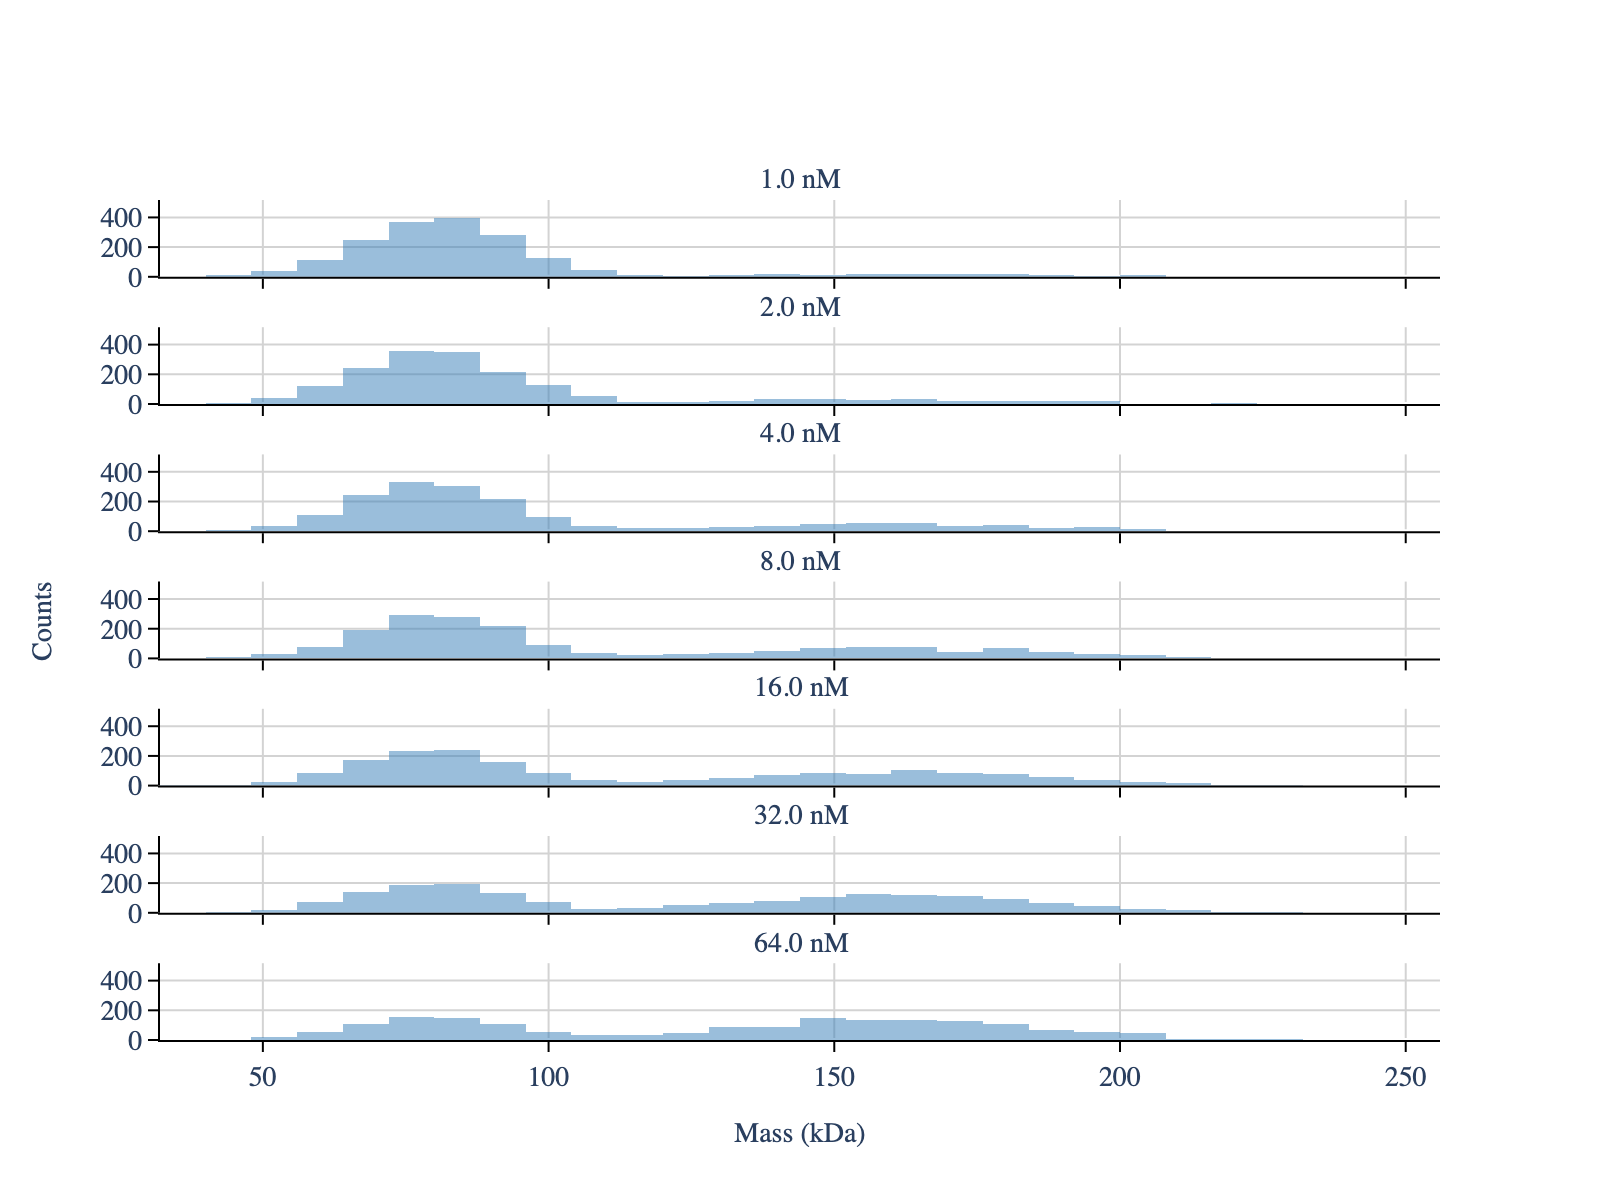

In [3]:
mp.apply_to_all(
    'create_histogram',
    window = [0,1000],
    bin_width = 8
)

layout_config = LayoutConfig(
    stacked=True,  # One plot per file
    show_subplot_titles=True,  # Hide subplot titles
    vertical_spacing=0.06,  # Vertical spacing between subplots
    extra_padding_y_label=0.03  # Extra padding for y-axis label to avoid overlap with axis ticks
)

fig = plot_histogram(mp, layout_config=layout_config)
display_figure_static(fig)

In [4]:
# Fit the multigaussian model to the histogram
mp.apply_to_all(
    'fit_histogram',
    peaks_guess=[70,160],
    mean_tolerance=40,
    std_tolerance=50,
    baseline=0
)

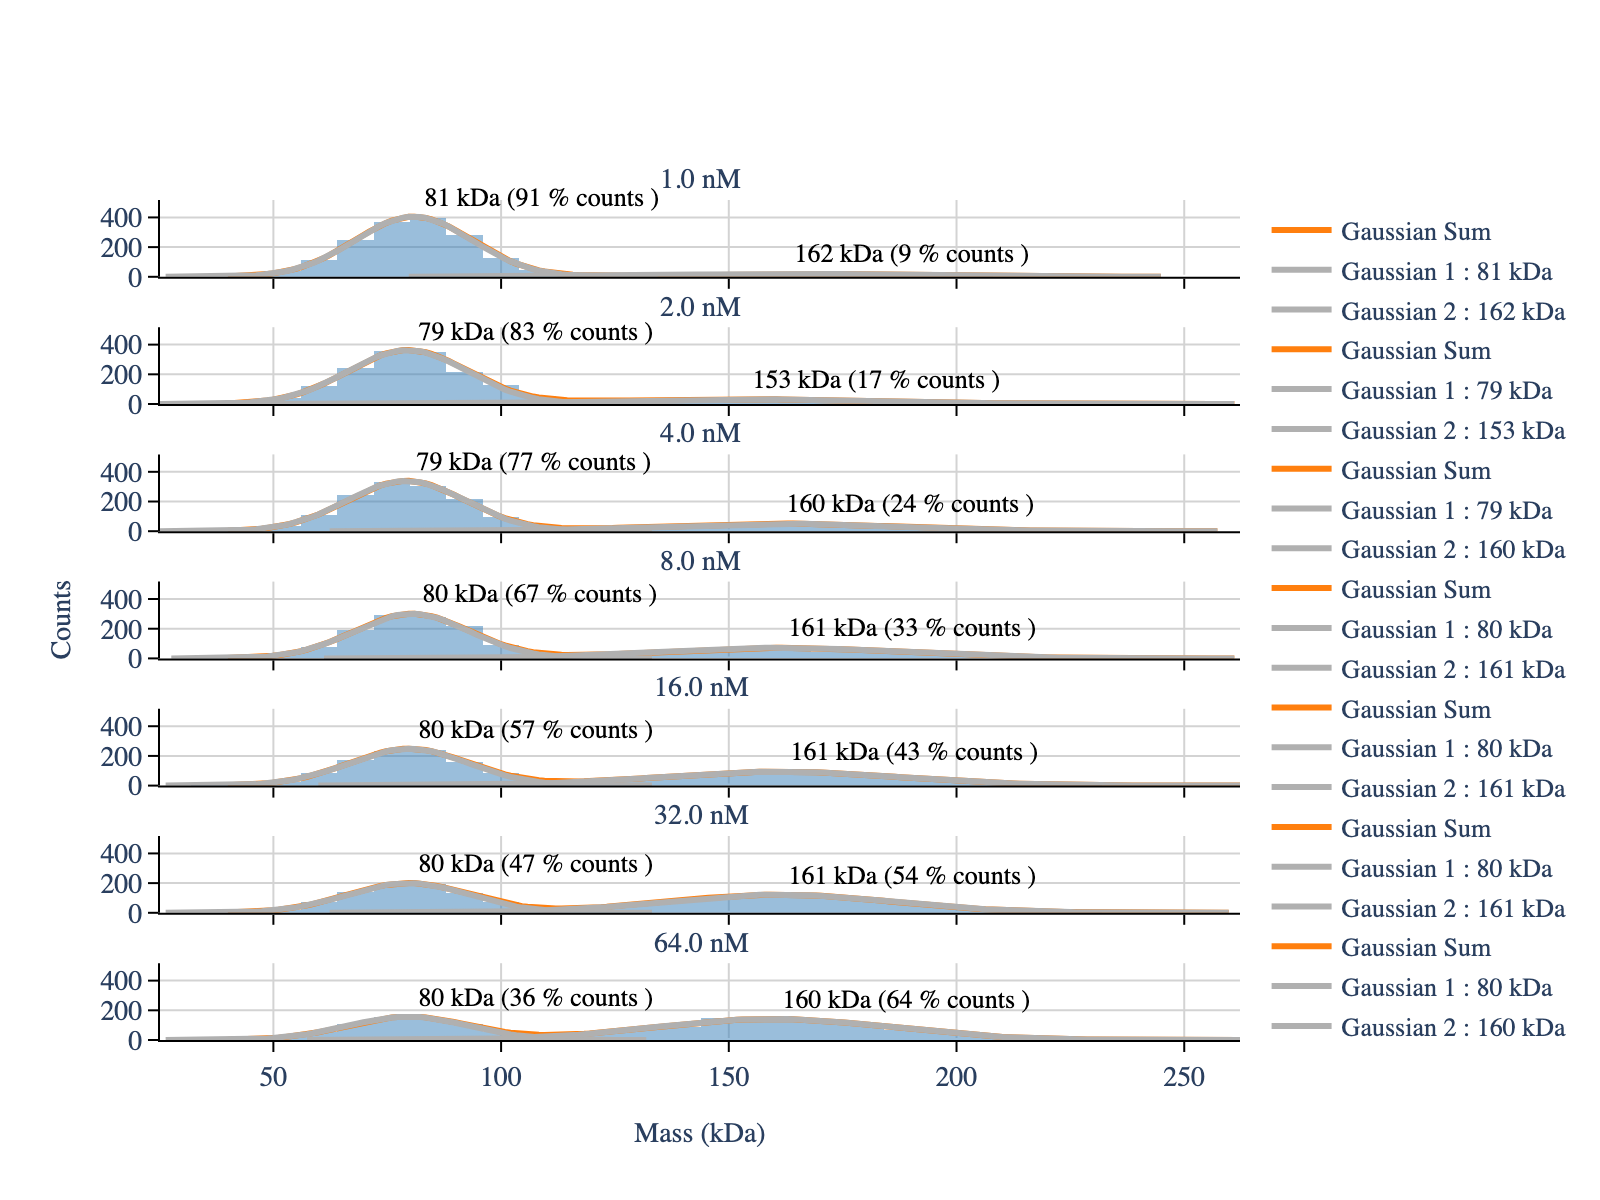

In [5]:
# Plot the fittings
fig = plot_histograms_and_fits(
    mp,
    layout_config=layout_config
)
display_figure_static(fig)

In [6]:
# See the number of counts for one of the files
first_model = list(mp.models.keys())[0]

print(mp.models[first_model].fit_table[['Position / kDa', 'Counts']])

   Position / kDa       Counts
0       80.795464  1635.887985
1      162.250030   157.095439


In [7]:
# Extract the counts for all models
counts_monomers = []
counts_dimers   = []

total_monomer_concentration = np.array(concentrations)  # Convert to numpy array

for model_name in list(mp.models.keys()):
    model = mp.models[model_name]
    counts_monomers.append(model.fit_table['Counts'].iloc[0])
    counts_dimers.append(model.fit_table['Counts'].iloc[1])

counts_monomers = np.array(counts_monomers)
counts_dimers   = np.array(counts_dimers)

In [8]:

factor_dimer   = counts_dimers   * 2
factor_monomer = counts_monomers * 1
sum_factors = factor_dimer + factor_monomer

concentration_monomer = counts_monomers * total_monomer_concentration / sum_factors
concentration_dimer   = counts_dimers   * total_monomer_concentration / sum_factors

# Verify that the calculated concentrations are correct - the division below should yield 1
(concentration_monomer + concentration_dimer * 2) / total_monomer_concentration


array([1., 1., 1., 1., 1., 1., 1.])

In [9]:
concentration_dimer

array([ 0.08055851,  0.28965269,  0.76603152,  1.9986568 ,  4.82392934,
       11.14974511, 24.90061752])

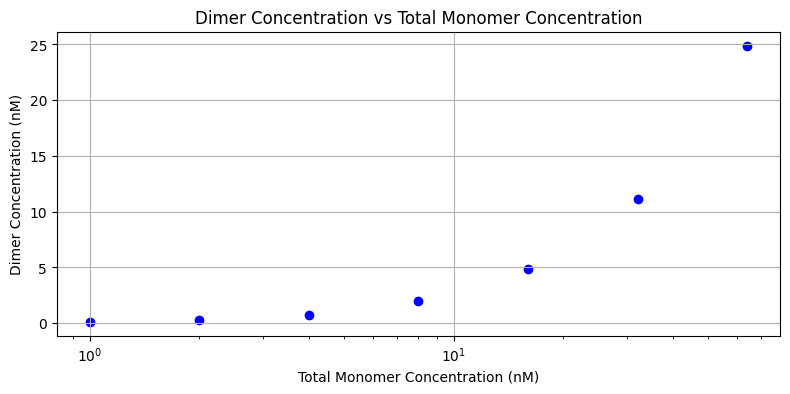

In [10]:

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.scatter(total_monomer_concentration, concentration_dimer, marker='o', linestyle='-', color='blue')
plt.xlabel('Total Monomer Concentration (nM)')
plt.ylabel('Dimer Concentration (nM)')
plt.title('Dimer Concentration vs Total Monomer Concentration')
plt.grid(True)
plt.xticks(total_monomer_concentration)
plt.tight_layout()
# log scale for x-axis
plt.xscale('log')
plt.show()

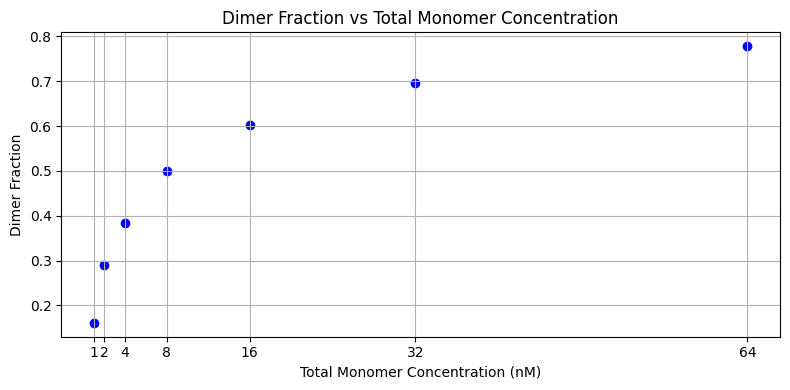

In [11]:
dimer_fraction = concentration_dimer * 2 / (concentration_dimer * 2 + concentration_monomer)

plt.figure(figsize=(8, 4))
plt.scatter(total_monomer_concentration, dimer_fraction, marker='o', linestyle='-', color='blue')
plt.xlabel('Total Monomer Concentration (nM)')
plt.ylabel('Dimer Fraction')
plt.title('Dimer Fraction vs Total Monomer Concentration')
plt.grid(True)
plt.xticks(total_monomer_concentration)
plt.tight_layout()
plt.show()

In [12]:
from scipy.optimize import curve_fit

# Create a function to fit the dimer fraction and estimate Kd
def fx_dimer_fraction(total_monomer_concentration,Kd):

    free_monomer = (- Kd + np.sqrt(Kd**2 + 8*total_monomer_concentration * Kd)) / 4

    dimer_conc   = (total_monomer_concentration - free_monomer) / 2

    dimer_fraction   = dimer_conc*2  / (total_monomer_concentration) 

    return dimer_fraction

params, cov = curve_fit(
    fx_dimer_fraction,
    xdata=total_monomer_concentration,
    ydata=dimer_fraction,
    p0=[1],
    bounds=(0, np.inf)
)

# Fitted Kd value in nM units:
print(f"Fitted Kd: {params[0]:.2f} nM")


Fitted Kd: 7.98 nM


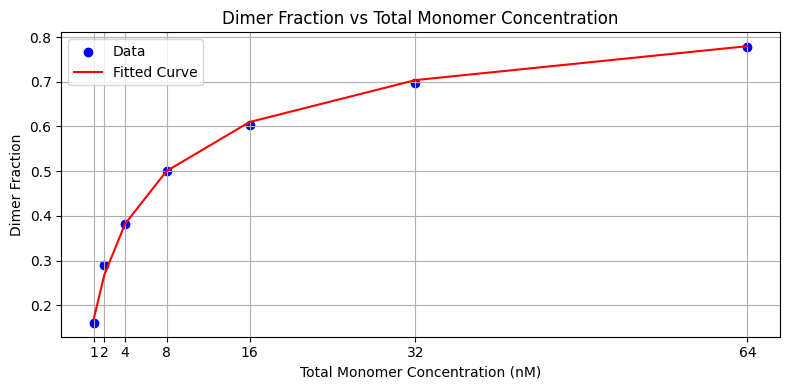

In [13]:
# Plot the fitting
plt.figure(figsize=(8, 4))
plt.scatter(total_monomer_concentration, dimer_fraction, marker='o', color='blue', label='Data')
plt.plot(total_monomer_concentration, fx_dimer_fraction(total_monomer_concentration, params[0]), color='red', label='Fitted Curve')
plt.xlabel('Total Monomer Concentration (nM)')
plt.ylabel('Dimer Fraction')
plt.title('Dimer Fraction vs Total Monomer Concentration')
plt.legend()
plt.grid(True)
plt.xticks(total_monomer_concentration)
plt.tight_layout()
plt.show()
# --- IGNORE ---